### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

# Loading dataset

In [1]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-cw8dfycv
  Running command git clone --filter=blob:none -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-cw8dfycv
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 740dab561ccf54a9ae4bb5bda3b8b18df3790025
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached efficientnet_pytorch-0.6.3.tar.gz (16 kB)
  Preparing metadata (setup.py) ... done
  Using cached pretrainedmodels-0.7.4.tar.gz (58 kB)
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 23.3 MB 14.7 MB/s            
  Using cached timm-0.4.12-py3-none-any.whl (376 kB)
     |████████████████████████████████| 881.9 MB 6.9 kB/s              �███████████       | 687.1 MB 92.9 MB/s eta 0:00:03 

In [2]:
#!pip install "opencv-python-headless<4.3"

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torchvision

In [4]:
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module


from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [5]:
#Traing dataset in gdrive.
#from google.colab import drive
#drive.mount('/content/gdrive')

In [6]:
import pathlib
import glob


x_train_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/leftImg8bit/train"))
y_train_seg_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/gtFine/train"))
y_train_dep_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/disparity/train"))

x_valid_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/leftImg8bit/val"))
y_valid_seg_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/gtFine/val"))
y_valid_dep_dir = pathlib.Path(os.path.join(os.getcwd(), "Cityscapes/disparity/val"))

'''
x_train_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/train")
y_train_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/train")
y_train_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/train")

x_valid_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/val")
y_valid_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/val")
y_valid_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/val")

x_test_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/test")
y_test_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/test")
y_test_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/test")
'''

'\nx_train_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/train")\ny_train_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/train")\ny_train_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/train")\n\nx_valid_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/val")\ny_valid_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/val")\ny_valid_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/val")\n\nx_test_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/leftImg8bit/test")\ny_test_seg_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/gtFine/test")\ny_test_dep_dir = pathlib.Path("/content/gdrive/MyDrive/dataset/disparity/test")\n'

In [7]:
SIZE_X = 224 
SIZE_Y = 224

# Dataloader and utility functions 

In [8]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

In [9]:
from torch.utils.data import Dataset


# classes for data loading and preprocessing
class CityDataset(Dataset):
    
    CLASSES =   ['road','sidewalk','building','wall','fence','pole',
                'traffic light','traffic sign','vegetation','terrain','sky',
                'person','rider','car','truck','bus',
                'train','motorcycle','bicycle','unlabeled']

    def __init__(
            self, 
            images_dir, 
            masks_dir,
            dep_dir, 
            classes=None, 
            transform=None, 
            preprocessing=None,
    ):
        
        lis_x = sorted(os.listdir(images_dir)) 
        lis_y_seg = sorted(os.listdir(masks_dir))
        lis_y_dep = sorted(os.listdir(dep_dir))

        self.images_fps = [image for link in lis_x for image in sorted(glob.glob(os.path.join(images_dir,link)+'/*.png'))]
        self.masks_fps = [image for link in lis_y_seg for image in sorted(glob.glob(os.path.join(masks_dir,link)+'/*.png'))]
        self.depth_fps = [image for link in lis_y_dep for image in sorted(glob.glob(os.path.join(dep_dir,link)+'/*.png'))]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.transform = transform
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        sample = {}
        # read data.
        image = cv2.imread(self.images_fps[i])
        image = cv2.resize(image, (SIZE_Y, SIZE_X))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample['image'] = image

        #Read Maskdata.
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))

        # extract certain classes from mask (e.g. cars)
        masks = []
        for v in self.class_values:
            if v == 19:
                masks.append((mask == 255))
            else :
                masks.append((mask == v))

        mask = np.stack(masks, axis=-1).astype('float')

        sample['seg'] = mask

        #Read Depth-data.
        dep = cv2.imread(self.depth_fps[i])
        dep = cv2.resize(dep, (SIZE_Y, SIZE_X))

        sample['dep'] = dep

        # apply augmentations
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['seg']

        # apply preprocessing
        if self.preprocessing:
            sample['image'] = self.preprocessing(sample['image'])
            #image, mask = sample['image'], sample['mask']          
 
        t= torchvision.transforms.ToTensor()
        
        sample['image'] = t(sample['image']).to(torch.float)
        sample['seg'] = t(sample['seg']).to(torch.float)
        sample['dep'] = t(sample['dep'][:,:,0]).to(torch.float)
        #norm  = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #sample['image'] = norm(sample['image'])
 
   

        return sample
        
    def __len__(self):
        return len(self.images_fps)


In [10]:
# Lets look at data we have
dataset = CityDataset(x_train_dir, y_train_seg_dir,y_train_dep_dir, classes=['car', 'person'])

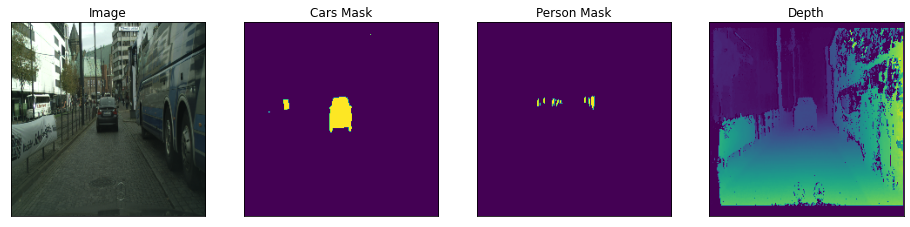

In [11]:
ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
mask = dataset[ids]['seg']
dep = dataset[ids]['dep']

visualize(
    image=image.data.numpy().transpose(1,2,0), 
    cars_mask=mask.data.numpy().transpose(1,2,0)[..., 0],
    Person_mask=mask.data.numpy().transpose(1,2,0)[..., 1],
    depth = np.stack(dep.data.numpy().transpose(1,2,0)[:,:,0]*3,axis=0)
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [12]:
import functools

def preprocess_input(x, mean=None, std=None, input_range=None, **kwargs):

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x

def get_preprocessing_fn():
    formatted_settings = {}
    formatted_settings["input_range"] = [0, 1]
    formatted_settings["mean"] = [0.485, 0.456, 0.406]
    formatted_settings["std"] = [0.229, 0.224, 0.225]
    return functools.partial(preprocess_input, **formatted_settings)

In [13]:
# Lets look at augmented data we have
#norm  = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = CityDataset(x_train_dir, y_train_seg_dir,y_train_dep_dir, classes=['car', 'person'],transform=None,preprocessing=get_preprocessing_fn())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


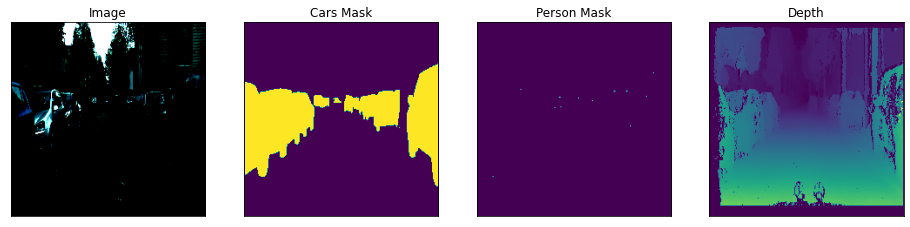

In [14]:
ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
mask = dataset[ids]['seg']
dep = dataset[ids]['dep']

visualize(
    image=image.data.numpy().transpose(1,2,0), 
    cars_mask=mask.data.numpy().transpose(1,2,0)[..., 0],
    Person_mask=mask.data.numpy().transpose(1,2,0)[..., 1],
    depth = np.stack(dep.data.numpy().transpose(1,2,0)[:,:,0]*3,axis=0)
)

# Model parameters defination.

In [15]:
#Database.
Train_Batch_size = 8
Val_Batch_size = 8
nworkers = 4

#Optimiser and Scheduler.
epochs = 85
#Lr = 0.0001
Lr = 0.001
#Model Parameters

CLASSES = ['road','sidewalk','building','wall','fence','pole',
                'traffic light','traffic sign','vegetation','terrain','sky',
                'person','rider','car','truck','bus',
                'train','motorcycle','bicycle','unlabeled']

#CLASSES = ['car', 'person']
Num_channels = 3

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation+ Background
activation = 'sigmoid' if n_classes == 1 else 'softmax'

# Temperature parameter for DWA.
T = 2.0

#task-type .
task_type = 'multi'  # Select 'single' or 'multi'

In [16]:
%pip install easydict

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached easydict-1.9.tar.gz (6.4 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=6350 sha256=52c8d9b7d9701efb5cc313a051c2a24e3e9f99b0804ef42650895f4d4fec0c69
  Stored in directory: /home/ec2-user/.cache/pip/wheels/5d/79/e4/4e55effe206295359b37e0f9db3e68a1197ba396682807dadb
Successfully built easydict
Note: you may need to restart the kernel to use updated packages.


In [17]:
from easydict import EasyDict as edict

FLAGVALS = cv2.INTER_NEAREST 
INFER_FLAGVALS = cv2.INTER_NEAREST

p =edict()
p['NAMES'] = ['seg','dep']
p['NUM_OUTPUT'] = {'seg':n_classes,'dep':1}
p['FLAGVALS'] = {'seg':FLAGVALS,'dep':FLAGVALS}
p['INFER_FLAGVALS'] = {'seg':INFER_FLAGVALS,'dep':INFER_FLAGVALS}

In [18]:
import warnings

def get_output(output,task):
    output = output.permute(0, 2, 3, 1)

    if task == 'seg':
        _, output = torch.max(output, dim=3)
    elif task == 'dep':
        pass
    else:
        raise ValueError("Invalid Selection")
    
    return output

#General Model evaluator
@torch.no_grad()
def eval_model_results(data_loader,model,n_classes=20, has_bg=False):
    n_classes = n_classes + int(has_bg)

    # Iterate
    tp = [0] * n_classes
    fp = [0] * n_classes
    fn = [0] * n_classes

    total_rmses = 0.0
    total_log_rmses = 0.0
    n_valid = 0.0
    output = dict()

    model.eval()
    for ii, sample in enumerate(data_loader):      
        inputimg = sample['image'].cuda(non_blocking=True) 
        gt_masks = sample['seg'].cuda(non_blocking=True)
        gt_deps = sample['dep'].cuda(non_blocking=True)

        output['seg'],output['dep'] = model(inputimg)
        
        for i,task in enumerate(p.NAMES):
          output[task] = get_output(output[task],task)
        
        gt_masks = get_output(gt_masks,'seg')
        gt_deps = get_output(gt_deps,'dep')

        #print(gt_masks.shape,output.shape)

        for jj in range(int(inputimg.size()[0])):
            #Segmentation evaluation.
            pred_mask = output['seg'][jj].cpu().data.numpy().squeeze()
            gt_mask = gt_masks[jj].cpu().data.numpy().squeeze()
              ##Semantic Segmentaion.               
              # resize - cv2.resize(output_task[jj], dsize=(meta['im_size'][1][jj], meta['im_size'][0][jj]), interpolation=p.TASKS.INFER_FLAGVALS[task])
      
            valid = (gt_mask != 255)

            if pred_mask.shape != gt_mask.shape:
                warnings.warn('Prediction and ground truth have different size. Resizing Prediction..')
                pred_mask = cv2.resize(pred_mask, gt_mask.shape[::-1], interpolation=cv2.INTER_NEAREST)

            # TP, FP, and FN evaluation
            for i_part in range(0, n_classes):
                tmp_gt = (gt_mask == i_part)
                tmp_pred = (pred_mask == i_part)
                tp[i_part] += np.sum(tmp_gt & tmp_pred & valid)
                fp[i_part] += np.sum(~tmp_gt & tmp_pred & valid)
                fn[i_part] += np.sum(tmp_gt & ~tmp_pred & valid)

            #Depth estimation.
            pred_dep = output['dep'][jj].cpu().data.numpy().squeeze()
            gt_dep = gt_deps[jj].cpu().data.numpy().squeeze()

            if pred_dep.shape != gt_dep.shape:
                warnings.warn('Prediction and ground truth have different size. Resizing Prediction..')
                pred_dep = cv2.resize(pred_dep, gt_dep.shape[::-1], interpolation=cv2.INTER_LINEAR)

            valid_mask = (gt_dep != 0)
            n_valid += np.sum(valid_mask)

            gt_dep[gt_dep == 0] = 1e-9 # Avoid overflow/underflow
            pred_dep[pred_dep <= 0] = 1e-9

            log_rmse_tmp = (np.log(gt_dep[valid_mask]) - np.log(pred_dep[valid_mask])) ** 2
            total_log_rmses += np.sum(log_rmse_tmp)

            rmse_tmp = (gt_dep[valid_mask] - pred_dep[valid_mask]) ** 2
            total_rmses += np.sum(rmse_tmp)


    jac = [0] * n_classes
    for i_part in range(0, n_classes):
        jac[i_part] = float(tp[i_part]) / max(float(tp[i_part] + fp[i_part] + fn[i_part]), 1e-8)
  
    # Write results
    eval_result = dict()
    eval_result['jaccards_all_categs'] = jac
    eval_result['mIoU'] = np.mean(jac)
    eval_result['rmse'] = np.sqrt(total_rmses / n_valid)
    eval_result['log_rmse'] = np.sqrt(total_log_rmses / n_valid)

    return eval_result


In [19]:
#Directory for result storage.
def mkdir_if_missing(directory):
    if not os.path.exists(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

root = os.path.join(os.getcwd(),'results')

output_dir = os.path.join(root, 'CityScapes', 'UNet', 'MTL_Baseline')
save_dir = os.path.join(output_dir, 'results')
checkpoint = os.path.join(output_dir, 'checkpoint.pth.tar')
best_model = os.path.join(output_dir, 'best_model.pth.tar')

mkdir_if_missing(output_dir)
mkdir_if_missing(save_dir)

#Building the model.

In [20]:
#Importing resnet backbone network
backbone = torchvision.models.resnet.resnet50(pretrained=True)
backbone_channels = 2048

In [21]:
#Designing a Resnet50 decoder.
class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x

class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)

class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


In [22]:
class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=2, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
            nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2)
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out

In [23]:
class UNet_Resnet50Decoder(nn.Module):
    DEPTH = 6

    def __init__(self,backbone,tasks):
        super().__init__()
        resnet = backbone
        self.tasks = tasks.keys()
        down_blocks = []
        up_blocks = []
        att_blocks = []
        
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        
        self.bridge = Bridge(2048, 2048)
        
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        #self.up_blocks = nn.ModuleList(up_blocks)
        
        att_blocks.append(AttentionBlock(2048,1024,512))
        att_blocks.append(AttentionBlock(1024,512,256))
        att_blocks.append(AttentionBlock(512,256,128))
        att_blocks.append(AttentionBlock(256,64,64))
        att_blocks.append(AttentionBlock(128,3,32))
        
        #self.att_blocks = nn.ModuleList(att_blocks)

        self.up_blocks = torch.nn.ModuleDict()
        self.att_blocks= torch.nn.ModuleDict()
        self.out = torch.nn.ModuleDict()
        
        for task in self.tasks:
            self.up_blocks[task] = nn.ModuleList(up_blocks)
            self.att_blocks[task] = nn.ModuleList(att_blocks)
            self.out[task] = nn.Conv2d(64, tasks[task], kernel_size=1, stride=1)

    def forward(self, x):
        
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNet_Resnet50Decoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        y = self.bridge(x)
        x = self.bridge(x)
        
        
        for i, block in enumerate(self.up_blocks['seg'], 1):
            key = f"layer_{UNet_Resnet50Decoder.DEPTH - 1 - i}"
            a_x = self.att_blocks['seg'][i-1](x,pre_pools[key])
            x = block(x, a_x)
            
        for i, block in enumerate(self.up_blocks['dep'], 1):
            key = f"layer_{UNet_Resnet50Decoder.DEPTH - 1 - i}"
            a_y = self.att_blocks['dep'][i-1](y,pre_pools[key])
            y = block(y, a_y)

        del pre_pools
        
        return self.out['seg'](x),self.out['dep'](y)

In [24]:
#creating the model
#heads = torch.nn.ModuleDict({task: UNet_Resnet50Decoder(backbone, n_classes=p.NUM_OUTPUT[task]) for task in p.NAMES})
task_out = {task: p.NUM_OUTPUT[task] for task in p.NAMES}
model = UNet_Resnet50Decoder(backbone, task_out)

In [25]:
if torch.cuda.is_available():
    model.cuda()
#model

# Traning the model.

In [26]:
#from torchsummary import summary

#print(summary(model,(Num_channels,SIZE_X,SIZE_Y)))

In [27]:
#Log Handlers.
loss_logger = []
Metrics_train_logger = []
Metrics_val_logger = []
batch_weight = []

In [28]:
import segmentation_models_pytorch as smp

In [29]:
#define the crireia

#Cross-entropyloss
class SoftMaxwithLoss(Module):
    """
    This function returns cross entropy loss for semantic segmentation
    """

    def __init__(self):
        super(SoftMaxwithLoss, self).__init__()
        #self.softmax = nn.LogSoftmax(dim=1)
        #self.criterion = nn.NLLLoss(ignore_index=255)
        #self.criterion = smp.losses.DiceLoss(mode='multiclass',classes = [x for x in range(n_classes)])
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, out, label):
        assert not label.requires_grad
        # out shape  batch_size x channels x h x w
        # label shape batch_size x 1 x h x w
        #label = label[:, 0, :, :].long()
        loss = self.criterion(out, label)

        return loss

#Depth-loss
class DepthLoss(nn.Module):
    """
    Loss for depth prediction. By default L1 loss is used.  
    """
    def __init__(self, loss='l1'):
        super(DepthLoss, self).__init__()
        if loss == 'l1':
            self.loss = nn.L1Loss()

        else:
            raise NotImplementedError('Loss {} currently not supported in DepthLoss'.format(loss))

    def forward(self, out, label):
        mask = (label != 255)
        return self.loss(torch.masked_select(out, mask), torch.masked_select(label, mask))

def get_loss(task=None):
    """ Return loss function for a specific task """
    if task == 'seg' :
        criterion = SoftMaxwithLoss()
    elif task == 'dep':
        criterion = DepthLoss()
    else:
        raise NotImplementedError('Undefined Loss: Choose a task among '
                                  'edge, semseg, human_parts, sal, depth, or normals')

    return criterion

class MultiTaskLoss(nn.Module):
    def __init__(self, tasks: list, loss_ft: nn.ModuleDict, loss_weights: dict):
        super(MultiTaskLoss, self).__init__()
        assert(set(tasks) == set(loss_ft.keys()))
        assert(set(tasks) == set(loss_weights.keys()))
        self.tasks = tasks
        self.loss_ft = loss_ft
        self.loss_weights = loss_weights
        #self.loss_scale = nn.Parameter(torch.tensor([-0.5]*len(tasks))).cuda()
    
    def forward(self, pred, gt):
        out = {task: self.loss_ft[task](pred[task], gt[task]) for task in self.tasks}
        #self.loss_weights = {task: 1/(2*torch.exp(torch.tensor([-0.5])).cuda()) for task in self.tasks}
        out['total'] = torch.pow(torch.prod(torch.stack([self.loss_weights[t] * out[t] for t in self.tasks])),1.0/len(self.tasks))
        #losses = torch.tensor([self.loss_ft[task](pred[task], gt[task]) for task in self.tasks]).cuda()
        #out['total'] = (losses/(2*self.loss_scale.exp())+self.loss_scale/2).sum()
        return out

def get_criterion():
    loss_ft = torch.nn.ModuleDict({task: get_loss(task) for task in p.NAMES})
    loss_weights = {'seg':0.5,'dep':0.5}
    return MultiTaskLoss(p.NAMES, loss_ft, loss_weights)

criterion = get_criterion()

if torch.cuda.is_available():
    criterion.cuda()

# define optomizer
optimizer = optim.Adam(model.parameters(), lr=Lr, weight_decay=1e-8)


In [30]:
# Dataset for train images
train_dataset = CityDataset(
    x_train_dir, 
    y_train_seg_dir,
    y_train_dep_dir, 
    classes=CLASSES, 
    transform=None,
    preprocessing=get_preprocessing_fn(), #smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS),
)

# Dataset for validation images
valid_dataset = CityDataset(
    x_valid_dir, 
    y_valid_seg_dir,
    y_valid_dep_dir, 
    classes=CLASSES, 
    transform=None,
    preprocessing=get_preprocessing_fn(), #smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS),
)


In [31]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=Train_Batch_size, shuffle=True,drop_last=True,
                              num_workers=nworkers )
valid_dataloader = DataLoader(valid_dataset, batch_size=Val_Batch_size, shuffle=False,drop_last=True,
                              num_workers=nworkers )


In [32]:
# Resume from checkpoint
if os.path.exists(checkpoint):
    checkpoint = torch.load(checkpoint, map_location='cpu')
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.load_state_dict(checkpoint['model'])
    start_epoch = checkpoint['epoch']
    best_result = checkpoint['best_result']
    loss_logger = checkpoint['loss_logger']
    Metrics_train_logger = checkpoint['Metrics_train_logger']
    Metrics_val_logger = checkpoint['Metrics_val_logger']    
else:
    start_epoch = 0
    best_result = eval_model_results(valid_dataloader,model,n_classes=n_classes)

In [33]:
# PyTorch TensorBoard support
#from torch.utils.tensorboard import SummaryWriter
#from datetime import datetime

In [34]:
#Tracking functions.
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def get_loss_meters():
    """ Return dictionary with loss meters to monitor training """
    losses = {}
    losses['seg'] = AverageMeter('Loss %s' %('seg'), ':.4e')
    losses['dep'] = AverageMeter('Loss %s' %('dep'), ':.4e')
    losses['total'] = AverageMeter('Loss Total', ':.4e')
    return losses


In [35]:
class SemsegMeter(object):
    def __init__(self,n_classes,cat_names,has_bg = False):
        self.n_classes = n_classes + int(has_bg)
        self.cat_names = cat_names
        self.tp = [0] * self.n_classes
        self.fp = [0] * self.n_classes
        self.fn = [0] * self.n_classes

    @torch.no_grad()
    def update(self, pred, gt):
        pred = pred.squeeze()
        gt = gt.squeeze()
        valid = (gt != 255)
    
        for i_part in range(0, self.n_classes):
            tmp_gt = (gt == i_part)
            tmp_pred = (pred == i_part)
            self.tp[i_part] += torch.sum(tmp_gt & tmp_pred & valid).item()
            self.fp[i_part] += torch.sum(~tmp_gt & tmp_pred & valid).item()
            self.fn[i_part] += torch.sum(tmp_gt & ~tmp_pred & valid).item()

    def reset(self):
        self.tp = [0] * self.n_classes
        self.fp = [0] * self.n_classes
        self.fn = [0] * self.n_classes
            
    def get_score(self, verbose=True):
        jac = [0] * self.n_classes
        for i_part in range(self.n_classes):
            jac[i_part] = float(self.tp[i_part]) / max(float(self.tp[i_part] + self.fp[i_part] + self.fn[i_part]), 1e-8)

        eval_result = dict()
        eval_result['jaccards_all_categs'] = jac
        eval_result['mIoU'] = np.mean(jac)


        if verbose:
            print('\nSemantic Segmentation mIoU: {0:.4f}\n'.format(100 * eval_result['mIoU']))
            class_IoU = eval_result['jaccards_all_categs']
            for i in range(len(class_IoU)):
                spaces = ''
                for j in range(0, 20 - len(self.cat_names[i])):
                    spaces += ' '
                print('{0:s}{1:s}{2:.4f}'.format(self.cat_names[i], spaces, 100 * class_IoU[i]))

        return eval_result

class DepthMeter(object):
    def __init__(self):
        self.total_rmses = 0.0
        self.total_log_rmses = 0.0
        self.n_valid = 0.0

    @torch.no_grad()
    def update(self, pred, gt):
        pred, gt = pred.squeeze(), gt.squeeze()
        
        # Determine valid mask
        mask = (gt != 0).bool()
        self.n_valid += mask.float().sum().item() # Valid pixels per image
        
        # Only positive depth values are possible
        pred = torch.clamp(pred, min=1e-9)
        gt = torch.clamp(gt, min=1e-9)
        
        # Per pixel rmse and log-rmse.
        log_rmse_tmp = torch.pow(torch.log(gt.to(torch.float)) - torch.log(pred.to(torch.float)), 2)
        log_rmse_tmp = torch.masked_select(log_rmse_tmp, mask)
        self.total_log_rmses += log_rmse_tmp.sum().item()

        rmse_tmp = torch.pow(gt - pred, 2)
        rmse_tmp = torch.masked_select(rmse_tmp, mask)
        self.total_rmses += rmse_tmp.sum().item()

    def reset(self):
        self.rmses = []
        self.log_rmses = []
        
    def get_score(self, verbose=True):
        eval_result = dict()
        eval_result['rmse'] = np.sqrt(self.total_rmses / self.n_valid)
        eval_result['log_rmse'] = np.sqrt(self.total_log_rmses / self.n_valid)

        if verbose:
            print('Results for depth prediction')
            for x in eval_result:
                spaces = ''
                for j in range(0, 15 - len(x)):
                    spaces += ' '
                print('{0:s}{1:s}{2:.4f}'.format(x, spaces, eval_result[x]))
                #print('{0:4f}{1:s}{2:.4f}'.format(self.total_rmses, spaces, self.n_valid))

        return eval_result


class PerformanceMeter(object):
    """ A general performance meter which shows performance across one or more tasks """
    def __init__(self,n_classes,cat_names,has_bg = False):
        self.meters ={'seg': SemsegMeter(n_classes,cat_names,has_bg), 'dep': DepthMeter() }

    def reset(self):
        self.meters['seg'].reset()
        self.meters['dep'].reset()

    def update(self, pred, gt,task):
        self.meters[task].update(pred, gt)

    def get_score(self,task,verbose=True):
        eval_dict = {}
        eval_dict[task] = self.meters[task].get_score(verbose)

        return eval_dict

In [36]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [37]:
def adjust_learning_rate(optimizer, epoch):
    """ Adjust the learning rate """
    lr = Lr

    lambd = pow(1-(epoch/epochs), 0.9)
    lr = lr * lambd

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return lr

In [38]:
def train_vanilla(train_loader, model, criterion, optimizer, epoch):
    """ Vanilla training with fixed loss weights """
    avg_loss = dict()
    avg_loss['total'] = 0
    avg_loss['seg'] = 0
    avg_loss['dep'] = 0

    num = 0
    
    losses = get_loss_meters()
    performance_meter = PerformanceMeter(n_classes,CLASSES,has_bg = False)
    progress = ProgressMeter(len(train_loader),
        [v for v in losses.values()], prefix="Epoch: [{}]".format(epoch))
    
    model.train()
    
    for i, batch in enumerate(train_loader):
        # Forward pass
        targets = dict()
        output = dict()

        images = batch['image'].cuda(non_blocking=True)
        targets['seg'] = get_output(batch['seg'].cuda(non_blocking=True),'seg')
        targets['dep'] = batch['dep'].cuda(non_blocking=True)
        output['seg'],output['dep'] = model(images)

        #print(output['seg'].shape,targets['seg'].shape)
        #print(output['dep'].shape,targets['dep'].shape)
        
        # Measure loss and performance
        loss_dict = criterion(output, targets)
        for k, v in loss_dict.items():
            losses[k].update(v.item())
        
        performance_meter.update(get_output(output['seg'],'seg'),targets['seg'],'seg')
        performance_meter.update(get_output(output['dep'],'dep'),get_output(targets['dep'],'dep'),'dep')
        
        # Backward
        optimizer.zero_grad()
        loss_dict['total'].backward()
        optimizer.step()

        if i % (Train_Batch_size-1) == 0:
            progress.display(i)
            
        with torch.no_grad():
            avg_loss['total'] += loss_dict['total']
            avg_loss['seg'] += loss_dict['seg']
            avg_loss['dep'] += loss_dict['dep']
            num += 1 
    
    eval_results = dict()
    eval_results.update(performance_meter.get_score('seg',verbose = True))
    eval_results.update(performance_meter.get_score('dep',verbose = True))

    avg_loss['total'] = avg_loss['total'].cpu() / num
    avg_loss['seg'] = avg_loss['seg'].cpu() / num
    avg_loss['dep'] = avg_loss['dep'].cpu() / num
    
    batch_weight.append(criterion.loss_weights)
    print("Epoch current weigts seg {0}, dep {1} ".format(criterion.loss_weights['seg'],criterion.loss_weights['dep']))

    return eval_results,avg_loss

In [39]:
thresh = 0.4

def validate_results(current, reference):
    if ((current['mIoU'] > reference['mIoU']) or ((current['log_rmse'] + thresh) < reference['log_rmse'])):
        print('New best semgentation model %.2f -> %.2f' %(100*reference['mIoU'], 100*current['mIoU']))
        print('New best depth model %.2f -> %.2f' %(reference['log_rmse'], current['log_rmse']))
        improvement = True
    else:
        print('No new best semgentation model %.2f -> %.2f' %(100*reference['mIoU'], 100*current['mIoU']))
        print('No new best depth model %.2f -> %.2f' %(reference['log_rmse'], current['log_rmse']))
        improvement = False

    if improvement: # Return result
        return True, current
    else:
        return False, reference


In [40]:
for epoch in range(start_epoch, epochs):
    print('Epoch {0}/{1}'.format(epoch+1, epochs))
    
        # Adjust lr
    if epoch > 15:
        lr = adjust_learning_rate(optimizer, epoch)
        print('Adjusted learning rate to {:.5f}'.format(lr))
  
    # Train 
    print('Train ...')
    eval_train,avg_loss = train_vanilla(train_dataloader, model, criterion, optimizer, epoch)

    loss_logger.append(avg_loss)
    Metrics_train_logger.append(eval_train)  

    # Evaluate
    # Check if need to perform eval first
    if epoch + 1 > epochs - 70:
        eval_bool = True
    else:
        eval_bool = False

    # Perform evaluation
    if eval_bool:
        print('Evaluate ...')
        curr_result = eval_model_results(valid_dataloader,model,n_classes=n_classes)
        Metrics_val_logger.append(curr_result)
        improves, best_result = validate_results(curr_result, best_result)
        if improves:
            print('Save new best model')
            torch.save(model.state_dict(),best_model)

    # Checkpoint
    print('Checkpoint ...')
    '''
    if (epoch + 1)%5  == 0 :
        torch.save({'optimizer': optimizer.state_dict(), 'model': model.state_dict(), 
                'epoch': epoch + 1, 'best_result': best_result,'loss_logger':loss_logger,
                'Metrics_train_logger':Metrics_train_logger,'Metrics_val_logger':Metrics_val_logger}, checkpoint)
    '''

Epoch 66/85
Adjusted learning rate to 0.00027
Train ...
Epoch: [65][  0/130]	Loss seg 2.0808e-01 (2.0808e-01)	Loss dep 2.1100e-02 (2.1100e-02)	Loss Total 3.3130e-02 (3.3130e-02)
Epoch: [65][  7/130]	Loss seg 2.1628e-01 (2.1052e-01)	Loss dep 1.2211e-02 (1.3755e-02)	Loss Total 2.5695e-02 (2.6728e-02)
Epoch: [65][ 14/130]	Loss seg 1.8058e-01 (2.0304e-01)	Loss dep 1.4819e-02 (1.3546e-02)	Loss Total 2.5865e-02 (2.6075e-02)
Epoch: [65][ 21/130]	Loss seg 2.0114e-01 (1.9999e-01)	Loss dep 1.3702e-02 (1.3229e-02)	Loss Total 2.6249e-02 (2.5588e-02)
Epoch: [65][ 28/130]	Loss seg 1.7759e-01 (1.9828e-01)	Loss dep 1.1179e-02 (1.3521e-02)	Loss Total 2.2278e-02 (2.5750e-02)
Epoch: [65][ 35/130]	Loss seg 2.0688e-01 (1.9910e-01)	Loss dep 1.2745e-02 (1.3420e-02)	Loss Total 2.5674e-02 (2.5711e-02)
Epoch: [65][ 42/130]	Loss seg 2.0697e-01 (1.9705e-01)	Loss dep 1.3841e-02 (1.3585e-02)	Loss Total 2.6761e-02 (2.5740e-02)
Epoch: [65][ 49/130]	Loss seg 2.0500e-01 (1.9785e-01)	Loss dep 1.2807e-02 (1.3415e-02)	Los

# Evaluate the model

In [41]:
model.load_state_dict(torch.load(best_model))
Eval_stats = eval_model_results(valid_dataloader,model,n_classes=n_classes)

In [42]:
Eval_stats

{'jaccards_all_categs': [0.8695644382958602,
  0.3976484830698118,
  0.7164741371915477,
  0.0741142609714475,
  0.06528658000647639,
  0.20249945401671285,
  0.0773457564355253,
  0.1524495027748824,
  0.7774815665835757,
  0.29436310606716914,
  0.8040980644957482,
  0.3243404992080702,
  0.036502574530189236,
  0.7104363635636325,
  0.0420053344120138,
  0.09880667619900312,
  0.02311191384039066,
  0.025914491533352044,
  0.1914354881480911,
  0.5795631433417595],
 'mIoU': 0.323172091734263,
 'rmse': 0.041497504168261055,
 'log_rmse': 0.8028074004651818}

In [43]:
# Lets look at augmented data we have
dataset = CityDataset(x_valid_dir, y_valid_seg_dir,y_valid_dep_dir, classes=CLASSES,transform=None,preprocessing = get_preprocessing_fn())

In [44]:
ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
mask = dataset[ids]['seg']
dep = dataset[ids]['dep']


model.eval()
output = dict()

with torch.no_grad():
    output['seg'],output['dep'] = model(image[None,:,:,:].cuda())
    output['seg'] = get_output(output['seg'],'seg')

output['seg'] = (output['seg'].cpu().numpy())
output['dep'] = (output['dep'].squeeze().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


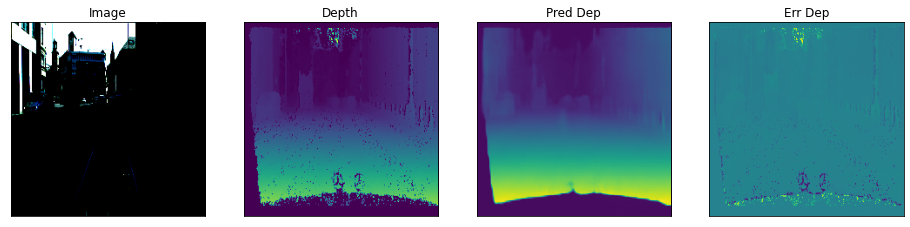

In [45]:
visualize(
    image=image.data.numpy().transpose(1,2,0), 
    depth = np.stack(dep.data.numpy().transpose(1,2,0)[:,:,0]*3,axis=0),
    Pred_dep = np.stack(output['dep']*3,axis=0),
    err_dep = np.stack(dep.data.numpy().transpose(1,2,0)[:,:,0]*3,axis=0) - np.stack(output['dep']*3,axis=0),
)

In [46]:
# Lets look at augmented data we have
dataset = CityDataset(x_valid_dir, y_valid_seg_dir,y_valid_dep_dir, classes=CLASSES,transform=None,preprocessing = get_preprocessing_fn())


In [50]:
ids = int(np.random.choice(np.arange(len(dataset)), size=1))

image = dataset[ids]['image'] # get some sample
mask = dataset[ids]['seg']
dep = dataset[ids]['dep']


model.eval()
output = dict()

with torch.no_grad():
    output['seg'],output['dep'] = model(image[None,:,:,:].cuda())
    output['seg'] = get_output(output['seg'],'seg')

output['seg'] = (output['seg'].cpu().numpy().transpose(1,2,0).squeeze())
output['dep'] = (output['dep'].squeeze().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


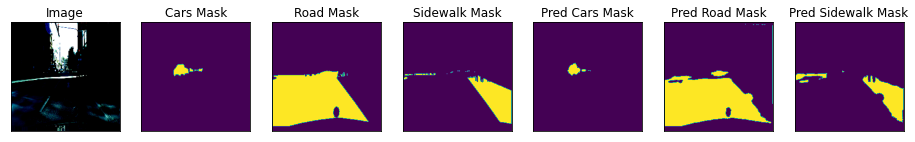

In [51]:
Pred_masks = []

for v in range(len(CLASSES)):
    if v == 19:
        Pred_masks.append(( output['seg'] == 255))
    else :
        Pred_masks.append((output['seg'] == v))

Pred_mask = np.stack(Pred_masks, axis=-1).astype('float')


visualize(
    image=image.data.numpy().transpose(1,2,0), 
    cars_mask=mask.data.numpy().transpose(1,2,0)[..., CLASSES.index('car')],
    road_mask=mask.data.numpy().transpose(1,2,0)[..., CLASSES.index('road')],
    sidewalk_mask=mask.data.numpy().transpose(1,2,0)[..., CLASSES.index('sidewalk')],    
    Pred_cars_mask=Pred_mask[..., CLASSES.index('car')],
    Pred_road_mask=Pred_mask[..., CLASSES.index('road')],
    Pred_sidewalk_mask=Pred_mask[..., CLASSES.index('sidewalk')],
)

In [52]:
loss_logger = torch.load(checkpoint)['loss_logger']

total_loss = []
seg_loss = []
dep_loss = []

for i in range(len(loss_logger)):
    total_loss.append(loss_logger[i]['total'])
    seg_loss.append(loss_logger[i]['seg'])
    dep_loss.append(loss_logger[i]['dep'])

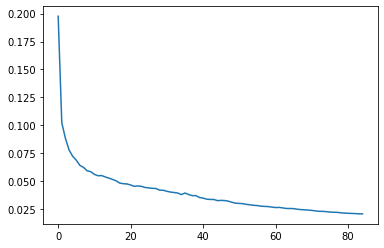

In [53]:
plt.plot(total_loss)

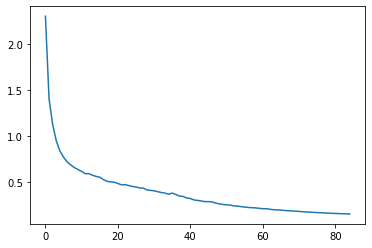

In [54]:
plt.plot(seg_loss)

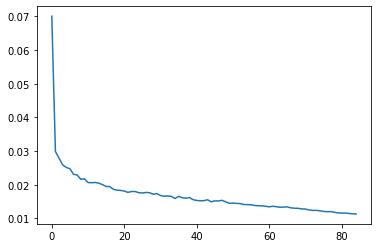

In [55]:
plt.plot(dep_loss)

In [56]:
#Metrics_train_logger = torch.load(checkpoint,map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))['Metrics_train_logger']

mIoU_train = []
rmse_train = []
log_rmse_train = []

for i in range(len(Metrics_train_logger)):
    mIoU_train.append(Metrics_train_logger[i]['seg']['mIoU'])
    rmse_train.append(Metrics_train_logger[i]['dep']['rmse'])
    log_rmse_train.append(Metrics_train_logger[i]['dep']['log_rmse']) 

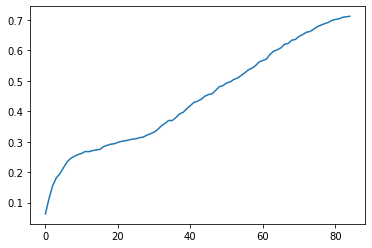

In [57]:
plt.plot(mIoU_train)

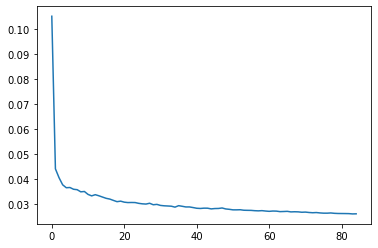

In [58]:
plt.plot(rmse_train)

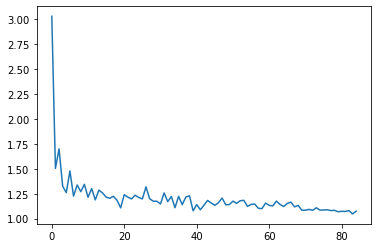

In [59]:
plt.plot(log_rmse_train)

In [60]:
Metrics_val_logger = torch.load(checkpoint,map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))['Metrics_val_logger']

mIoU_val = []
rmse_val = []
log_rmse_val = []

for i in range(len(Metrics_val_logger)):
    mIoU_val.append(Metrics_val_logger[i]['mIoU'])
    rmse_val.append(Metrics_val_logger[i]['rmse'])
    log_rmse_val.append(Metrics_val_logger[i]['log_rmse'])

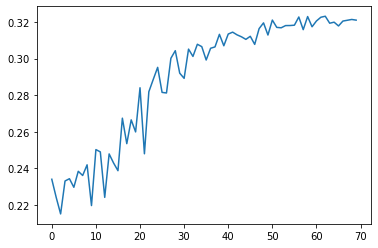

In [61]:
plt.plot(mIoU_val)

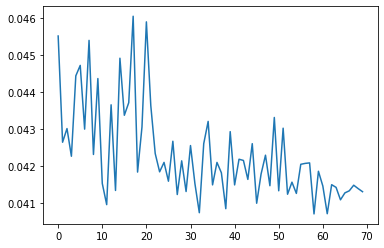

In [62]:
plt.plot(rmse_val)

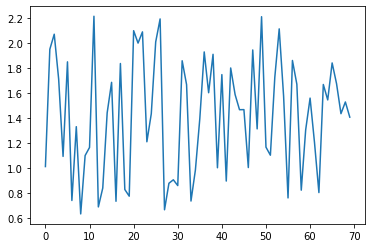

In [63]:
plt.plot(log_rmse_val)

Text(0, 0.5, 'mIou')

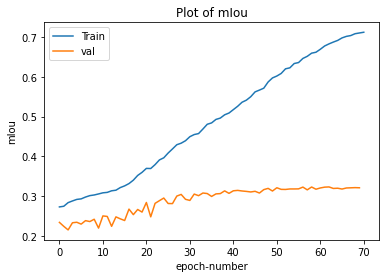

In [64]:
plt.plot(mIoU_train[14:],label='Train')
plt.plot(mIoU_val,label ='val')
plt.legend(loc="upper left")
plt.title("Plot of mIou")
plt.xlabel("epoch-number")
plt.ylabel("mIou")

Text(0, 0.5, 'log-rmse')

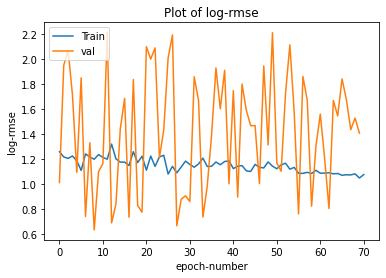

In [65]:
plt.plot(log_rmse_train[14:],label='Train')
plt.plot(log_rmse_val,label ='val')
plt.legend(loc="upper left")
plt.title("Plot of log-rmse")
plt.xlabel("epoch-number")
plt.ylabel("log-rmse")